<a href="https://colab.research.google.com/github/kindeerrrr/first_repository/blob/main/%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B%D0%94%D0%97_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных и предварительная информация

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки визуализации
sns.set_style('whitegrid')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (14, 5)

# Загрузка датасетов
df_country = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
df_state = pd.read_csv('GlobalLandTemperaturesByState.csv')
df_major_city = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
df_city = pd.read_csv('GlobalLandTemperaturesByCity.csv')

# Приводим даты к типу datetime
for df in [df_country, df_state, df_major_city, df_city]:
    df['dt'] = pd.to_datetime(df['dt'])

# Вывод размеров
print("Размеры таблиц:")
print(f"По странам - {df_country.shape}")
print(f"По штатам - {df_state.shape}")
print(f"По крупным городам - {df_major_city.shape}")
print(f"По городам - {df_city.shape}")

# Количество уникальных стран
print("\nКоличество уникальных стран:")
print(f"Страны: {df_country['Country'].nunique()}")
print(f"Штаты: {df_state['Country'].nunique()}")
print(f"Крупные города: {df_major_city['Country'].nunique()}")
print(f"Города: {df_city['Country'].nunique()}")

# Случайные 15 уникальных стран
print("\nСлучайные страны:")
print(df_country['Country'].dropna().sample(15, random_state=42).unique())

Размеры таблиц:
По странам - (577462, 4)
По штатам - (645675, 5)
По крупным городам - (239177, 7)
По городам - (8599212, 7)

Количество уникальных стран:
Страны: 243
Штаты: 7
Крупные города: 49
Города: 159

Случайные страны:
['Russia' 'Hungary' 'Denmark' 'Macau' 'Belgium' 'Indonesia' 'Turkey'
 'Belize' 'Guernsey' 'Angola' 'Iran' 'Macedonia' 'North America'
 'Costa Rica']


# Подготовка данных



Пропущено температур: 1
Диапазон дат: 1823-01-01 00:00:00 – 2013-09-01 00:00:00


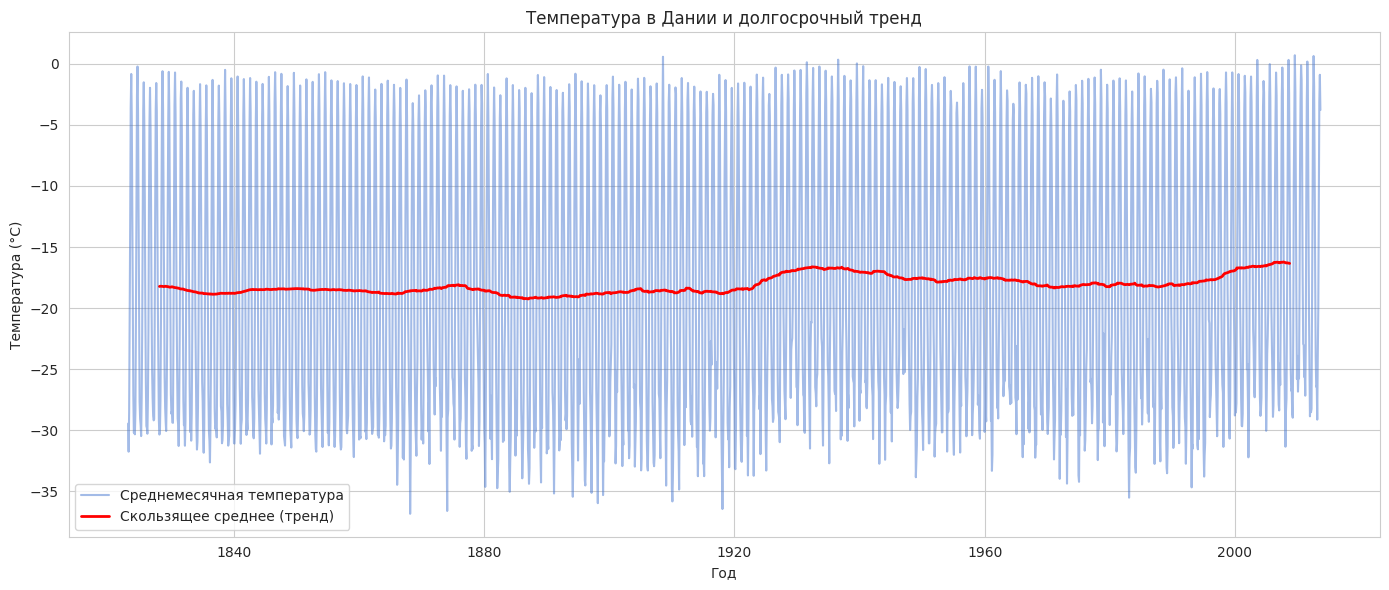

In [25]:
# Копируем нужные данные
df_dk = df_country[df_country['Country'] == 'Denmark'].copy()

# Проверка пропусков
print("Пропущено температур:", df_dk['AverageTemperature'].isna().sum())
print("Диапазон дат:", df_dk['dt'].min(), "–", df_dk['dt'].max())

# Убираем строки с пропущенной температурой
df_dk = df_dk.dropna(subset=['AverageTemperature'])

# Устанавливаем дату как индекс
df_dk = df_dk.set_index('dt')
df_dk = df_dk.sort_index()
ts_dk = df_dk['AverageTemperature'].resample('ME').mean()

# Визуализация временного ряда
# Строим скользящее среднее по температуре
rolling_mean = ts_dk.rolling(window=120, center=True).mean()  # 10 лет

# График: исходный ряд + тренд
plt.figure(figsize=(14, 6))
plt.plot(ts_dk, label='Среднемесячная температура', alpha=0.5)
plt.plot(rolling_mean, label='Скользящее среднее (тренд)', color='red', linewidth=2)
plt.title('Температура в Дании и долгосрочный тренд')
plt.xlabel('Год')
plt.ylabel('Температура (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Среднемесячная температура в Дании колеблется в ярко выраженном сезонном ритме. Видна стабильная цикличность с годами, при этом явного тренда на потепление или похолодание визуально не наблюдается

Скользящее среднее показывает слабую тенденцию к потеплению в последние десятилетия

# Holdout-разбиение

Размер train: 1830 месяцев
Размер test: 458 месяцев
Период train: 1823-01-31 — 1975-06-30
Период test: 1975-07-31 — 2013-08-31


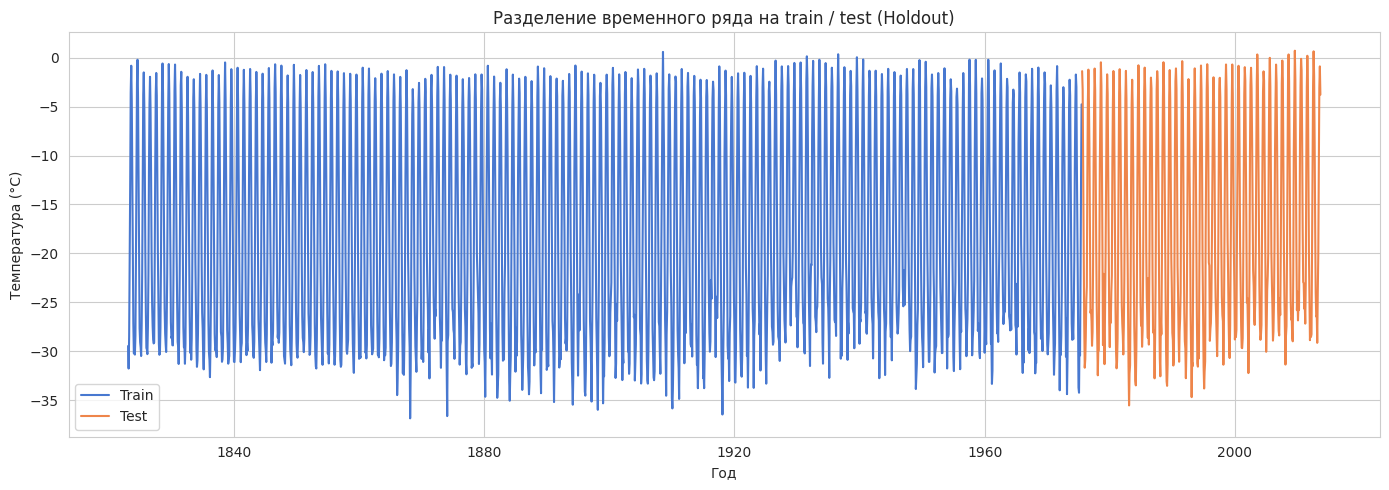

In [26]:
ts_dk_clean = ts_dk.dropna()

# Кол-во точек
n = len(ts_dk_clean)
train_size = int(n * 0.8)

# Holdout-разбиение
train_ts = ts_dk_clean.iloc[:train_size]
test_ts = ts_dk_clean.iloc[train_size:]

print(f'Размер train: {len(train_ts)} месяцев')
print(f'Размер test: {len(test_ts)} месяцев')
print(f'Период train: {train_ts.index.min().date()} — {train_ts.index.max().date()}')
print(f'Период test: {test_ts.index.min().date()} — {test_ts.index.max().date()}')

# Визуализация
plt.figure(figsize=(14, 5))
plt.plot(train_ts, label='Train')
plt.plot(test_ts, label='Test')
plt.title('Разделение временного ряда на train / test (Holdout)')
plt.xlabel('Год')
plt.ylabel('Температура (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Разбила временной ряд средних температур в Дании на две части:

1. обучающая выборка (train) содержит данные с января 1823 по июнь 1975 (1830 месяцев)
2. тестовая выборка (test) содержит данные с июля 1975 по август 2013 (458 месяцев)

Такое разбиение позволяет  тренировать модель на “прошлом”, а затем честно проверить её качество на “будущем”, не допуская утечек данных

In [27]:
split_point = int(len(ts_dk) * 0.8)
ts_train = ts_dk.iloc[:split_point]
ts_test = ts_dk.iloc[split_point:]

# Скользящее окно

Всего создано 142 скользящих окон.


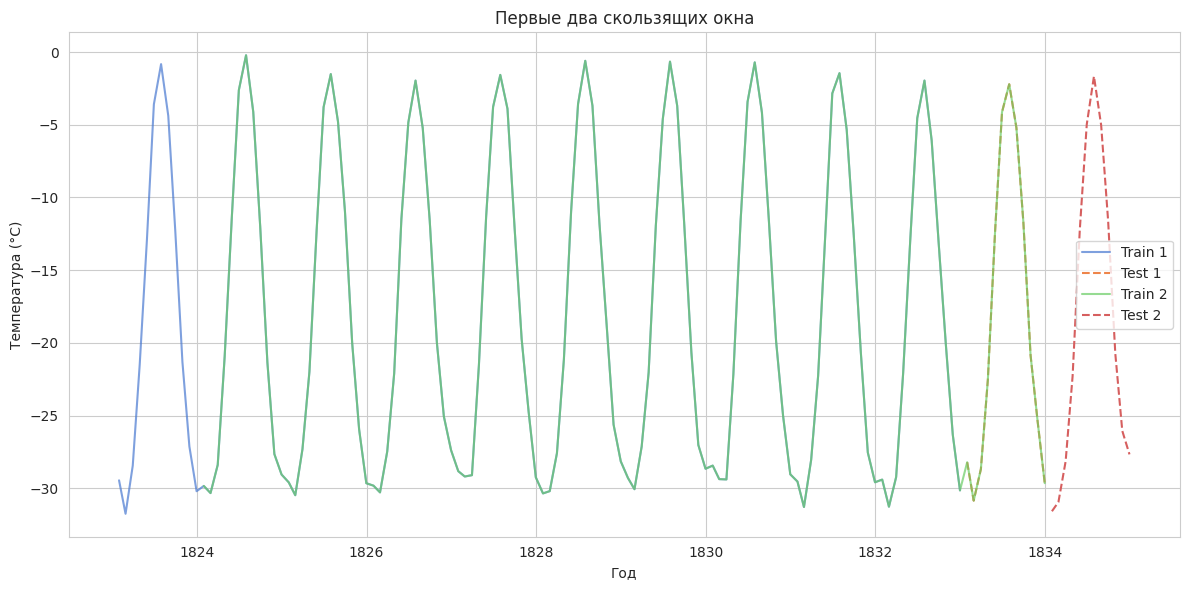

In [28]:
train_window = 120  # 10 лет
horizon = 12        # 12 месяцев (1 год)

splits = []

for start in range(0, len(ts_train) - train_window - horizon + 1, 12):  # с шагом в год
    train_slice = ts_train.iloc[start : start + train_window]
    test_slice = ts_train.iloc[start + train_window : start + train_window + horizon]
    splits.append((train_slice, test_slice))

print(f"Всего создано {len(splits)} скользящих окон.")

# Визуализируем первые 2 окна
plt.figure(figsize=(12, 6))

for i, (train_slice, test_slice) in enumerate(splits[:2]):
    plt.plot(train_slice.index, train_slice.values, label=f'Train {i+1}', alpha=0.7)
    plt.plot(test_slice.index, test_slice.values, label=f'Test {i+1}', linestyle='--')

plt.title('Первые два скользящих окна')
plt.xlabel('Год')
plt.ylabel('Температура (°C)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

Построила 142 скользящих окна, начиная с 1823 года. Каждое окно использует 10 лет данных для обучения и делает прогноз на следующий год. Такая техника позволяет реалистично оценить качество прогноза на разных временных отрезках

# Генерация признаков

In [29]:
# Преобразуем временной ряд в датафрейм и добавим признаки
df_features = ts_dk.copy().to_frame(name='target')

# Лаги
df_features['lag_1'] = df_features['target'].shift(1)
df_features['lag_12'] = df_features['target'].shift(12)

# Календарные признаки
df_features['month'] = df_features.index.month

# Добавим сезон
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

df_features['season'] = df_features['month'].apply(get_season)

# One-hot encoding по сезону (drop_first=True исключает autumn как базу)
df_features = pd.get_dummies(df_features, columns=['season'], drop_first=True)

# Покажем результат
df_features.head()

,target,lag_1,lag_12,month,season_spring,season_summer,season_winter
dt,,,,,,,
1823-01-31,-29.446,NaN,NaN,1,False,False,True
1823-02-28,-31.746,-29.446,NaN,2,False,False,True
1823-03-31,-28.439,-31.746,NaN,3,True,False,False
1823-04-30,-21.488,-28.439,NaN,4,True,False,False
1823-05-31,-12.925,-21.488,NaN,5,True,False,False


Я добавила в данные признаки: лаги на 1 и 12 месяцев, номер месяца, а также сезонность в виде отдельных колонок: весна, лето и зима (решила добавить сезонность не только по зиме, как в ДЗ). Теперь у модели есть больше информации о том, какие значения температуры были раньше и в какое время года это происходило

Эти признаки помогут ей лучше уловить сезонные закономерности и строить более точный прогноз

# Оценка прогноза

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Убираем пропуски, появившиеся из-за лагов
df_model = df_features.dropna()

# Разделим на train и test
split_date = ts_train.index[-1]  # граница между train и test
train_df = df_model[df_model.index <= split_date]
test_df = df_model[df_model.index > split_date]

# Признаки и целевая переменная
features = ['lag_1', 'lag_12', 'month', 'season_spring', 'season_summer', 'season_winter']
X_train, y_train = train_df[features], train_df['target']
X_test, y_test = test_df[features], test_df['target']

# Обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

# Прогноз
y_pred = model.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mape = (abs((y_test - y_pred) / y_test).mean()) * 100

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

MAE: 1.53
RMSE: 2.00
MAPE: 27.82%


* MAE (средняя абсолютная ошибка) = 1.53
* RMSE (корень из средней квадратичной ошибки) = 2.00
* MAPE (средняя абсолютная процентная ошибка) = 27.82%

1. Модель показывает хороший уровень точности: средняя ошибка составляет около 1.5°C, что вполне приемлемо для подобных задач (климатического прогнозирования)

2. RMSE лишь немного превышает MAE, что говорит об отсутствии сильных выбросов

3. Хотя MAPE получился высоким (около 28%), это объясняется малым значением температуры зимой, из-за чего процентная ошибка становится нестабильной

***Вывод:*** В целом модель успешно улавливает сезонные колебания и может использоваться как базовый прогноз

**Основные сложности:**
* Данные покрывают очень долгий исторический период, включая 1800 годы, когда измерения были менее точны
* Линейная модель не может уловить сложные нелинейные зависимости и тренды потепления

**Что на мой взгляд можно сделать для уменьшения показателя MAPE:**
1. Убрать месяцы, где y_true слишком близко к 0 (но возможно это будет считаться искажением реальности)
2. Заменить MAPE на другую метрику
3. Добавить еще больше каких-либо сезонных фич
4. Добавить больше лагов
5. Рассмотреть усложнённую модель например, добавить регрессоры с полиномиальными или скользящими средними признаками, использовать XGBoost или CatBoost
6. Убрать ранние годы с низкой точностью